ISSA Salim <br>
AIT RAHOU Abdelouahed <br>
10 Novembre 2024 <br>
MISC 2 - ULCO (2024-2025) <br>
## Résolution de programmes d'optimisation non linéaires par la méthode du point intérieur

### Importation des librairies

In [224]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

### Fonctions utilisées

In [225]:
def initial_objective(A,b,gamma,x):
    """Cette fonction calcule l'objectif économique du programme non linéaire défini."""
    f_x = (1/2)*(x.T @ A @ x) + x.T @ b + gamma
    return f_x

def barrier_objective(A,b,gamma,x,alpha):
    """Cette fonction calcule l'objectif économique de la fonction barrière logarithmique.
    alpha est le paramètre décroissant."""
    f_x = initial_objective(A,b,gamma,x) - alpha*np.sum(np.log(x))
    return f_x

def modified_barrier_objective(A,b,gamma,x,theta):
    """Cette fonction évalue l'objectif économique de la fonction barrière logarithmique 
    pour un paramètre thêta croissant."""
    f_x = theta*initial_objective(A,b,gamma,x) - np.sum(np.log(x))
    return f_x

def get_x_u_z(A,B,X):
    """Cette fonction extrait les variables x, u et z de la variable agrégée X = (x,u,z)^T."""
    x = X[0:A.shape[1],0]
    x = np.reshape(x,(x.shape[0],1))
    u = X[A.shape[1]:A.shape[1]+B.shape[0],0]
    u = np.reshape(u,(u.shape[0],1))
    z = X[A.shape[1]+B.shape[0]:,0]
    z = np.reshape(z,(z.shape[0],1))
    return x,u,z

def F(A,B,C,X,b,alpha):
    """Cette fonction calcule la valeur de F(x,u,z) à partir de X = (x,u,z)^T et la mettra à jour dans les ...
    itérations de la méthode de Newton."""
    e = np.ones((A.shape[1],1))
    x,u,z = get_x_u_z(A,B,X)
    D_x = Dx(x)
    F_X = np.block([[A@x+b-z+B.T@u],[B@x-C],[(D_x@z)-alpha*e]])
    return F_X

def Dx(x):
    """Cette fonction forme la matrice diagonale Dx."""
    D_x = np.diag(np.reshape(x,(x.shape[0],)))
    return D_x

def Dz(x,alpha):
    """Cette fonction forme la matrice diagonale Dz à partir de z."""
    D_x =  Dx(x) #Formation de la matrice Dx
    d = [1/D_x[i,i] for i in range(x.shape[0])]
    Dx_inverse = np.diag(d) #Formation de la matrice Dx^-1
    e = np.ones((x.shape[0],1))
    z = alpha*(Dx_inverse @ e)
    D_z = np.diag(np.reshape(z,(z.shape[0],)))
    return z,D_z

def gradF(A,B,X,alpha):
    """Cette fonction forme la matrice du gradient de F(x,u,z) et la mettra à jour dans les itérations...
    de la méthode de Newton."""
    x,u,z = get_x_u_z(A,B,X)
    D_x = Dx(x)
    z,D_z = Dz(x,alpha)
    grad_F = np.block([[A,B.T,-np.eye(A.shape[1])],[B,np.zeros((B.shape[0],B.shape[0])),np.zeros((B.shape[0],A.shape[1]))],[D_z,np.zeros((A.shape[1],B.shape[0])),D_x]])
    return grad_F
    
def newton_algorithm(A,B,C,X_old,b,alpha,tolerance,max_iterations,correctif):
    """Cet algorithme détermine la solution optimale pour une valeur de alpha."""
    newton_iterations_graph = np.array([[],[]]) #pour l'affichage de la convergence de la méthode de Newton
    iteration = 0
    optimum_found = 0
    for i in range(max_iterations): #algorithme de Newton
        iteration = i
        F_X = F(A,B,C,X_old,b,alpha)
        grad_F = gradF(A,B,X_old,alpha)
        Y = la.solve(grad_F,F_X)
        X_new = X_old - Y
        
        #Correctif de positivité pour palier les accumulations d'imprécisions numériques
        if correctif == 1:
            X_new[0:A.shape[1],0] = np.maximum(X_new[0:A.shape[1],0],tolerance)

        error = la.norm(X_new - X_old)
        #Stockage de l'itération et de l'erreur obtenue
        newton_iterations_graph = np.append(newton_iterations_graph,[[iteration+1],[error]],axis=1)

        if error <= tolerance:
            optimum_found = 1
            x_star,u_star,z_star = get_x_u_z(A,B,X_old)
            break
        else:
            X_old = X_new

    if optimum_found == 1:
        print("\tNewton: convergence après {0:2d} itérations.".format(iteration+1))
    else:
        print("\tNewton: pas de convergence.")
        x_star = -1*np.ones((A.shape[1],1)) #des valeurs négatives pour indiquer qu'on n'a pas trouvé de solution admissible
        u_star = -1*np.ones((B.shape[0],1))
        z_star = -1*np.ones((A.shape[1],1))
    return x_star,u_star,z_star,iteration,newton_iterations_graph

### Formation du programme non linéaire

In [226]:
#Génération de la matrice tridiagonale régulière A

A_size = int(50) #nombre de variables
epsilon = 2 #plus cette valeur est petite, plus la convergence est difficile
secondary_diag = [-1]*(A_size-1)
main_diag = [2+epsilon]*A_size
A = np.diag(main_diag)+np.diag(secondary_diag,-1)+np.diag(secondary_diag,1)
A = A.astype(np.float64) #passage en précision double

#A est symétrique et définie positive

b = np.random.randint(low=1,high=10,size=(A_size,1))
b = b.astype(np.float64)
gamma = np.random.randint(low=1,high=10)

#Génération des contraintes d'égalités

equalities_number = int(10) #equalities_number < A_size
B = np.random.randint(low=1,high=10,size=(equalities_number,A_size))
B = B.astype(np.float64)
#B[0,:],B[1,:] = B[1,:],B[0,:]

if equalities_number > A_size:
    print("Avertissement: il y a trop de contraintes et pas assez de variables.")

#Vérification que B est de rang maximal
B_rank = la.matrix_rank(B)
if B_rank != equalities_number:
    print("Avertissement: il y a des contraintes d'égalité redondantes.")

x_known = np.random.randint(low=1,high=10,size=(A_size,1)) #solution connue pour les contraintes d'égalités
x_known = x_known.astype(np.float64)
C = B @ x_known #génération du vecteur des constantes à partir d'une solution connue

#Génération des contraintes d'inégalités: on considère seulement que x >= 0

### Méthode de Newton pour résoudre l'équation F(x,u,z) = 0


- thêta =  1
	Newton: convergence après  5 itérations.
	Optimum trouvé.

- thêta = 20
	Newton: convergence après  4 itérations.
	Optimum trouvé.

- thêta = 400
	Newton: convergence après  4 itérations.
	Optimum trouvé.

- thêta = 8000
	Newton: convergence après  3 itérations.
	Optimum trouvé.

 Résidu de la solution calculée: 2.27e-13


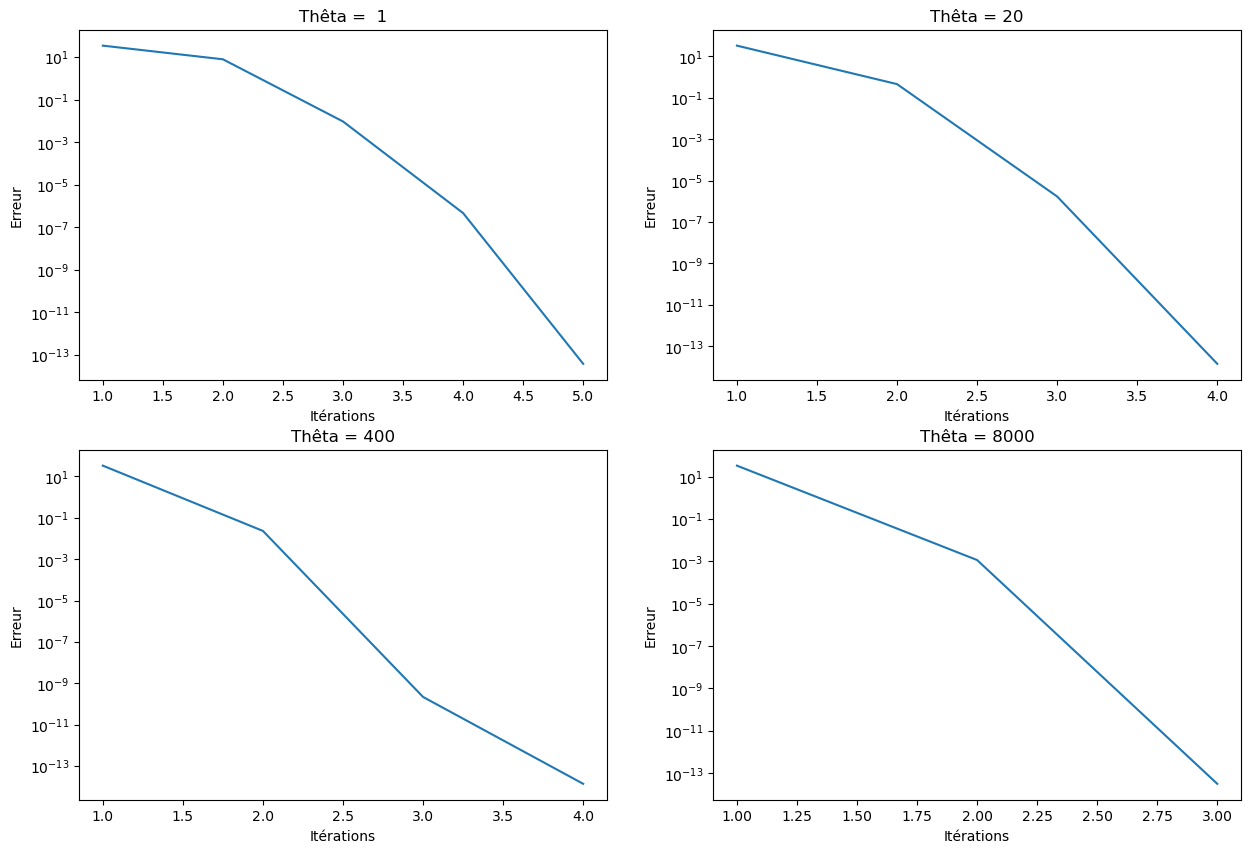

In [227]:
max_iterations = 50 #nombre maximal d'itérations de la méthode de Newton
theta = 1 #paramètre croissant de la fonction barrière logarithmique
alpha = 1/theta #paramètre décroissant de la fonction barrière logarithmique
tolerance = 1e-10

#Initialisation de (x0,u0,z0)
x_old = np.random.randint(low=1,high=10,size=(A_size,1))
x_old = x_old.astype(np.float64)
u_old = np.random.randint(low=1,high=10,size=(equalities_number,1))
u_old = u_old.astype(np.float64)
if np.all(x_old > 0) == False or np.all(u_old > 0) == False:
    print("Solution non admissible utilisée au démarrage.")

z_old,D_z = Dz(x_old,alpha) #initialisation de la variable z0 et formation de la matrice Dz

X_old = np.block([[x_old],[u_old],[z_old]])

D_x = Dx(x_old) #formation de la matrice Dx

#Démarrage des itérations de l'algorithme de Newton
multiplier = 20 #pour augmenter progressivement la valeur de theta

theta_max_iterations = 4 #nombre d'itérations sur les valeurs de thêta
correctif = 0 #correction pour respecter la contrainte de positivité dans les itérations de Newton

lines_number,columns_number = 2,2
fig,axes = plt.subplots(lines_number,columns_number,figsize=(15,10))
axes = axes.flatten()

i = 0
while i < theta_max_iterations: #boucle sur les valeurs de theta
    print("\n- thêta = {0:2d}".format(int(theta)))
    x_star,_,_,iteration,newton_iterations_graph = newton_algorithm(A,B,C,X_old,b,alpha,tolerance,max_iterations,correctif)
    
    #Affichage de la convergence
    if i < lines_number*columns_number:
        axes[i].semilogy(newton_iterations_graph[0,:],newton_iterations_graph[1,:])
        axes[i].set_xlabel("Itérations")
        axes[i].set_ylabel("Erreur")
        axes[i].set_title("Thêta = {0:2d}".format(int(theta)))
        
    if np.all(x_star >= 0): #la solution satisfait la contrainte de positivité
        print("\tOptimum trouvé.")
        correctif = 0
    else: #correctif pour ne pas violer la contrainte de positivité
        if correctif == 1: #correctif déjà appliqué, on passe à l'itération suivante
            print("\tPas d'optimum trouvé.")
            correctif = 0
        else:
            print("\tPas d'optimum trouvé. Redémarrage en appliquant le correctif ...")
            correctif = 1
            axes[i].cla()
            i -= 1
            theta /= multiplier
            alpha = 1/theta
        
    theta *= multiplier
    alpha = 1/theta
    
    i += 1

print('\n Résidu de la solution calculée: {0:2.2e}'.format(la.norm(B@x_star-C)))

plt.show()

### Affichage de l'amélioration de l'objectif de la fonction barrière pour les valeurs de theta

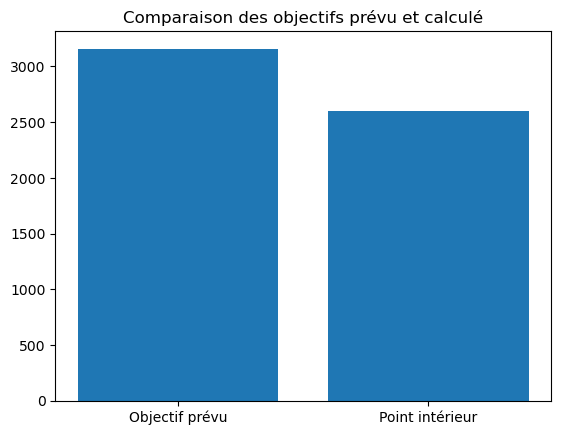

In [228]:
names = ['Objectif prévu','Point intérieur']
f_star_initial = initial_objective(A,b,gamma,x_known)[0,0]
f_star_computed = initial_objective(A,b,gamma,x_star)[0,0]
values = [f_star_initial,f_star_computed]
plt.bar(names,values)
plt.title("Comparaison des objectifs prévu et calculé")
plt.show()